# Exercise 12: Cross Validation
-----

In this exercise, we'll practice implementing cross validation techniques, including leave-one-out and k-fold cross validation. We'll use the `PimaIndiansDiabetes2` practice dataset, which has medical data on a group of Pima Native American women, including whether or not they have diabetes. This dataset is part of the `mlbench` package. We'll be using each person's medical history to predict whether or not they have been diagnosed with diabetes. 

# 1: Data (1 pts)
---

Load the `tidyverse`, `boot`, and `mlbench` packages (you may need to install `boot` and `mlbench`).

Load the `PimaIndiansDiabetes2` dataset using the `data()` function. Drop the `insulin` column (it just has a lot of missing data) and then drop `NA`s from the rest of the dataset. Save your updated dataset to a new variable name. Finally, print the dimensions of your new dataset, and look at the first few lines of data.

In [7]:
# install and load packages
install.packages("boot")
install.packages("mlbench")
library(tidyverse)
library(boot)
library(mlbench)

# load in data
data(PimaIndiansDiabetes)
head(PimaIndiansDiabetes)

# create new dataframe, dropping insulin aka selecting all other columns
pima_v2 <- PimaIndiansDiabetes %>% select(pregnant, glucose, pressure, triceps, mass, pedigree, age, diabetes)
head(pima_v2)

# drop NAs and make new dataframe aka final dataframe
pima <- drop_na(pima_v2)
head(pima) # look at first few lines

# dimensions
dim(pima) # 768 X 8;; 768 rows/observations

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



,pregnant,glucose,pressure,triceps,insulin,mass,pedigree,age,diabetes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,6,148,72,35,0,33.6,0.627,50,pos
2,1,85,66,29,0,26.6,0.351,31,neg
3,8,183,64,0,0,23.3,0.672,32,pos
4,1,89,66,23,94,28.1,0.167,21,neg
5,0,137,40,35,168,43.1,2.288,33,pos
6,5,116,74,0,0,25.6,0.201,30,neg


,pregnant,glucose,pressure,triceps,mass,pedigree,age,diabetes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,6,148,72,35,33.6,0.627,50,pos
2,1,85,66,29,26.6,0.351,31,neg
3,8,183,64,0,23.3,0.672,32,pos
4,1,89,66,23,28.1,0.167,21,neg
5,0,137,40,35,43.1,2.288,33,pos
6,5,116,74,0,25.6,0.201,30,neg


,pregnant,glucose,pressure,triceps,mass,pedigree,age,diabetes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,6,148,72,35,33.6,0.627,50,pos
2,1,85,66,29,26.6,0.351,31,neg
3,8,183,64,0,23.3,0.672,32,pos
4,1,89,66,23,28.1,0.167,21,neg
5,0,137,40,35,43.1,2.288,33,pos
6,5,116,74,0,25.6,0.201,30,neg


[1] 768   8

(Note that in medical contexts, `pedigree` refers to a system of measuring family history of a condition. So here, higher numbers mean greater family history of diabetes. You can read more about this dataset [here](https://rdrr.io/cran/mlbench/man/PimaIndiansDiabetes.html).)

# 2. Leave-one-out Cross Validation (4 pts)

In the tutorial, we learned how to fit leave-one-out cross validation using the `cv.glm` function from the `boot` package. But we can also do this manually using `predict()` like we have in the past.

Let's predict `diabetes`, a dichotomous outcome, using all the other variables in our modified dataset. 

First, fit a logistic regression model using all of the observations except the very first one. Then use your fitted model to predict whether your holdout case is positive or negative for diabetes. Remember that logistic regression coefficients are in **log-odds**, meaning that if an output is positive, the probability of the outcome is greater than 50%; if the output is negative, the probability of the outcome is less than 50%. 

Compare your result to the actual response in row one above. Did your model correctly classify this observation?

In [8]:
# train dataset for logistic regression model; not using currently
train.preds <- pima[-1,]
# head(train.preds)
# test dataframe (1st row); not using currently
test.inds <- pima[1,]
# head(test.inds)

# TRUE/FALSE indicator for whether each observation is a test item or not. 
pima$is.test <- 1:nrow(pima) %in% test.inds 
# head(pima)

# run logistic regression model
model1 = glm(diabetes ~ pregnant + glucose + pressure + triceps + mass + 
  pedigree + age, data = train.preds, family = "binomial")
summary(model1) # full model summary

predict_test = predict.glm(model1, test.inds) > 0 
predict_test
test.inds # correct, positive for diabetes, seen as TRUE


Call:
glm(formula = diabetes ~ pregnant + glucose + pressure + triceps + 
    mass + pedigree + age, family = "binomial", data = train.preds)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7292  -0.7291  -0.4179   0.7297   2.9022  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -8.253584   0.705169 -11.704  < 2e-16 ***
pregnant     0.124513   0.031932   3.899 9.64e-05 ***
glucose      0.033418   0.003436   9.725  < 2e-16 ***
pressure    -0.012938   0.005200  -2.488  0.01284 *  
triceps     -0.003443   0.006205  -0.555  0.57891    
mass         0.090144   0.015035   5.996 2.02e-09 ***
pedigree     0.913756   0.297847   3.068  0.00216 ** 
age          0.015347   0.009315   1.648  0.09945 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 991.38  on 766  degrees of freedom
Residual deviance: 724.42  on 759  degrees of freedom
AIC: 740

1 
TRUE

,pregnant,glucose,pressure,triceps,mass,pedigree,age,diabetes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,6,148,72,35,33.6,0.627,50,pos


So we just calculated a single iteration of LOOCV. We used 531 rows of our data to fit a model to predict the outcome of the last row. 

Below, use a `for` loop to iterate through the rest of your dataset doing the same thing. You will need to:
* Create a data frame `results` with two columns: one named `actual` which holds the true classification for each observation, and one named `predicted`, which should be filled with `NA`s. This is where you'll store the output of your loop.
* Create a loop that runs through each row of your data, pulls that observation out, trains your model on the remaining data, and then tests the fitted model on your test observation.
* Store your model *predictions* ("pos" or "neg" -- not the log-odds) in the `predicted` column of your `results` dataframe

After you run your loop, print the first few lines of `results`.

In [9]:
results  <- matrix(NA, nrow = nrow(pima), ncol = 1)
# see below for dataframe with the two columns specified: actual and predicted (called results)

#for loop
for (i in 1:nrow(pima)){ 
    # separate individual observation `i` from the rest of your data
    train.preds <- pima[-i,]
    test.inds <- pima[i,]
    # train your model
    model1 = glm(diabetes ~ pregnant + glucose + pressure + triceps + mass + 
      pedigree + age, data = train.preds, family = "binomial")
    # test model on hold out observation
    predict_test = predict.glm(model1, test.inds) > 0
    # classify model prediction as "pos" or "neg" and add to `results`
    results[i] = predict_test
}

head(results)

TRUE
FALSE
TRUE
FALSE
TRUE
FALSE


Now, calculate the overall error of your model. What proportion of cases were incorrectly classified?

In [10]:
pima$diabetes <- as.factor(pima$diabetes) 
pima$diabetes = ifelse(pima$diabetes == "pos", TRUE, FALSE) 
# if == pos, code as true, if not, code as false

# results now as a dataframe via tibble, not a matrix
# results column = predicted, add actual column in as well to get accuracy
data <- tibble(results = results, actual = pima$diabetes)
head(data)

# confusion matrix already set up; compare results aka predicted to actual for accuracy
print(paste("Accuracy:", mean(data$results == data$actual)))

results,actual
"<lgl[,1]>",<lgl>
TRUE,TRUE
FALSE,FALSE
TRUE,TRUE
FALSE,FALSE
TRUE,TRUE
FALSE,FALSE


[1] "Accuracy: 0.774739583333333"


# 3. Compare to `cv.glm` (3 pts)

Now, let's compare this result to the `cv.glm` function. Using the tutorial as a guide, use `cv.glm` to run LOOCV on the data, using the same model (i.e., still using all of the variables to predict diabetes diagnosis).

Note that, because this is a `classification` problem and not a regression problem like in the tutorial, we need to adjust the `cost` argument of `cv.glm`. We can read more about this in the docs:

In [11]:
# setting seed
set.seed(1)

# build model
model2 = glm(diabetes~ ., data = pima, family = "binomial")
cost <- function(r, pi = 0) mean (abs(r - pi) > .5)
cv.err = cv.glm(pima, model2, K = nrow(pima), cost = cost)
cv.err$delta

[1] 0.2291667 0.2292260

Here, we see `cost` is defined as: 
> "A function of two vector arguments specifying the cost function for the cross-validation. The first argument to cost should correspond to the **observed responses** and the second argument should correspond to the **predicted or fitted responses** from the generalized linear model."

In the example code (scroll to bottom of the docs), we see that the appropriate cost function for a binary classification is 

``
cost <- function(r, pi = 0) mean(abs(r-pi) > 0.5)
``

Where `r` is the vector of observed responses (technically "pos" and "neg", but R treats these as 1 and 0 under the hood), and `pi` is the vector of *probabilities* (not log-odds) fit by the model. Thus, this boils down to our error: what proportion of observations were incorrectly classified. You will need to include this code below.

In [12]:
# set seed again
set.seed(1)

# making another for loop
cv.error = rep(0, 10)
start.time <- Sys.time()
 for (i in 1:10) {
   model2 = glm(diabetes~ ., data = pima, family = "binomial")
   cv.err[i] = cv.glm(pima, model2)$delta[1]
 }

Time difference of 1.96828 mins

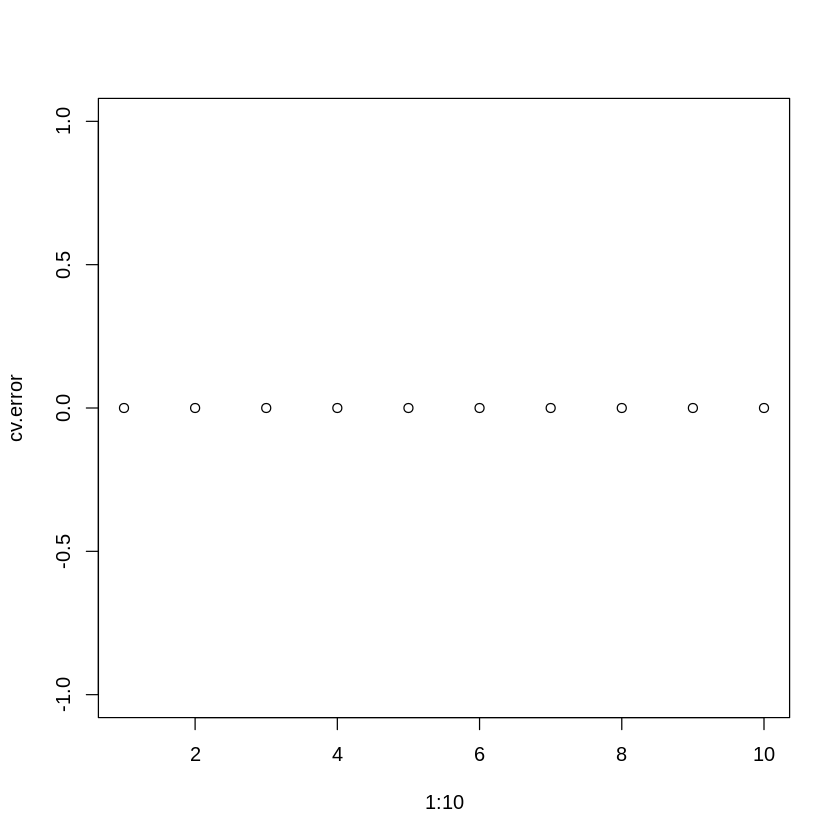

In [13]:
# I split up the code chunks bc the for loop takes forever run and I was
  # running this code iteritively line by line to make sure it worked

end.time <- Sys.time()

LOOtime <- end.time - start.time
LOOtime

plot(1:10, cv.error)

How do your results compare to your manual LOOCV above?

> *They look basically the same.*


# 4. Adjusting K and Reflection (2 pts)

Recall that LOOCV has some drawbacks. In particular, it has quite high *variance* which can lead to poor performance on new test data. We can reduce this variance by increasing K.

Below, re-run your cross validation using `cv.glm` with `k` set to 3, 5, 10, and 15. 

In [14]:
# set seed again
set.seed(1)

# original model info
model2 = glm(diabetes~ ., data = pima, family = "binomial") 
cost <- function(r, pi = 0) mean(abs(r - pi) > 0.5)

# K = 3
cv.err  = cv.glm(pima, model2, K = 3, cost = cost)
cv.err$delta 

# K = 5
cv.err  = cv.glm(pima, model2, K = 5, cost = cost)
cv.err$delta 

# # K = 10
cv.err  = cv.glm(pima, model2, K = 10, cost = cost)
cv.err$delta 

# # K = 15
cv.err  = cv.glm(pima, model2, K = 15, cost = cost)
cv.err$delta 

[1] 0.2434896 0.2413194

[1] 0.2291667 0.2260403

[1] 0.2304687 0.2304637

[1] 0.2369792 0.2355991

#### Reflection

How do your errors compare to your LOOCV error above? How do they change as k increases?
> *It appears that higher values of k result in a slight decrease in error. A k = 5 seems to have the lowest error for our model, but all the k's are pretty comparable.*

If you change the random seed above, you'll get slightly different errors. If you were to do the same with your LOOCV above , would you expect to get different results each time? Why or why not?
> *No, there wouldn't be a change for my LOOCV because LOOCV is fully exhaustive with its iterations, so there wouldn't really be a big change in our errors.*

**DUE:** 5pm March 27, 2023, got an extension until Friday, March 31st

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here.
> *Sara Jaramillo*